In [1]:
display_width = 100 # in percentage

from IPython.display import display, HTML
display(HTML("<style>.container { width:"+str(display_width)+"% !important; }</style>"))

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("/Users/sudhanshugupta/Library/Python/3.9/lib/python/site-packages")

In [4]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from EDA import EDA_medical_appointment
from preprocessing import preprocMedicalAppointment
from feature_extraction import featuresMedicalAppointment, feature_selection_permutation_importance, feature_selection_hierarchical_clustering
from classification import LogisticRegressionClf, RandomForestClf, MLPClf, XGBClf
from utils import train_val_test_split, compare_performances_across_classifiers

/Users/sudhanshugupta/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Data

In [6]:
df_medical_appointment = pd.read_csv("./data/medical_appointment_train.csv")
df_medical_appointment.rename(columns={"No-show": "no_show"}, inplace=True)
df_medical_appointment['no_show'].replace({"No": 0, "Yes": 1}, inplace=True)
feature_cols = [
    'PatientID', 'AppointmentID', 'Gender', 'ScheduledDay',
    'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
    'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received',
]
df_medical_appointment.sample(10)

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,no_show
20025,3.175593e+13,5665611,M,2016-05-05T14:55:28Z,2016-05-05T00:00:00Z,2,BELA VISTA,0,0,0,0,0,0,0
14073,8.765665e+10,5660744,M,2016-05-04T18:20:28Z,2016-05-13T00:00:00Z,56,MARUÍPE,0,0,0,0,0,0,0
83229,8.466818e+13,5706608,F,2016-05-17T08:34:13Z,2016-05-17T00:00:00Z,53,ITARARÉ,0,1,0,0,0,0,0
46978,4.373719e+13,5602541,M,2016-04-19T15:08:08Z,2016-05-18T00:00:00Z,20,ANTÔNIO HONÓRIO,0,0,0,0,0,0,1
68267,1.416561e+13,5546257,M,2016-04-05T15:45:23Z,2016-05-06T00:00:00Z,54,ANDORINHAS,0,0,0,0,0,0,0
52136,5.985752e+12,5720237,F,2016-05-19T13:30:56Z,2016-05-24T00:00:00Z,36,CRUZAMENTO,0,0,0,0,0,1,0
1161,8.938212e+11,5638594,F,2016-04-29T08:11:46Z,2016-04-29T00:00:00Z,16,GRANDE VITÓRIA,0,0,0,0,0,0,0
68533,4.197380e+11,5729121,M,2016-05-24T07:14:24Z,2016-05-24T00:00:00Z,39,MARIA ORTIZ,0,0,0,0,0,0,0
71123,7.253564e+13,5478099,M,2016-03-16T14:09:39Z,2016-05-25T00:00:00Z,66,FONTE GRANDE,0,1,0,1,0,1,1
77306,1.159426e+13,5662972,M,2016-05-05T09:18:01Z,2016-05-05T00:00:00Z,41,SANTO ANTÔNIO,0,1,0,0,0,0,0


# Exploratory Data Analysis

In [7]:
eda = EDA_medical_appointment(df_medical_appointment[feature_cols], df_medical_appointment['no_show'])

--------------------------------------------------
Checking feature datatypes and null values
--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientID       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hypertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handicap        110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage:

None

--------------------------------------------------
Describe continuous numerical features
--------------------------------------------------


,Age
count,110527.000000
mean,37.088874
std,23.110205
min,-1.000000
25%,18.000000
50%,37.000000
75%,55.000000
max,115.000000


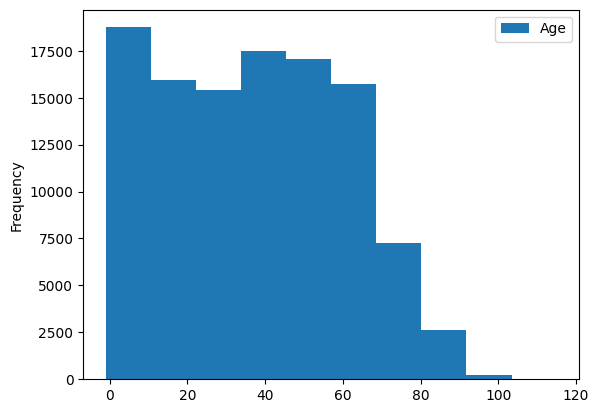

--------------------------------------------------
categorical features Probabilities
--------------------------------------------------


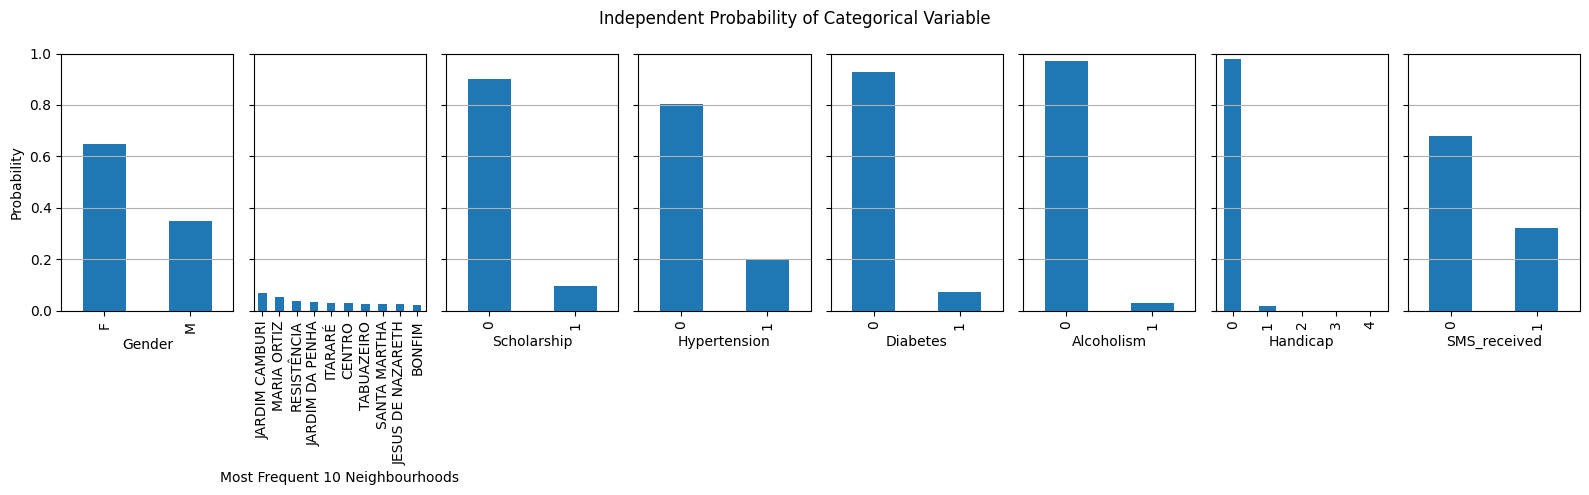

In [8]:
eda.describe_general_stats()

Min age < 0 in some cases. These are incorrect entries and for overall performance, it is desirable to remove these values from the dataset.

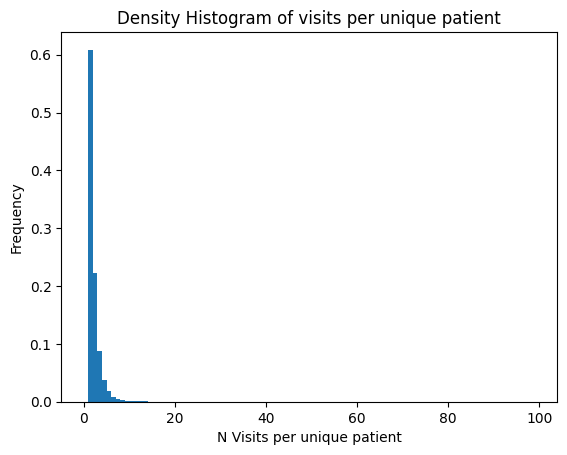

--------------------------------------------------
--------------------------------------------------
n_unique_patients = 62299
n_patients_less_than_3_visits = 51815
percent_patients_less_than_3_visits = 83%
--------------------------------------------------
--------------------------------------------------


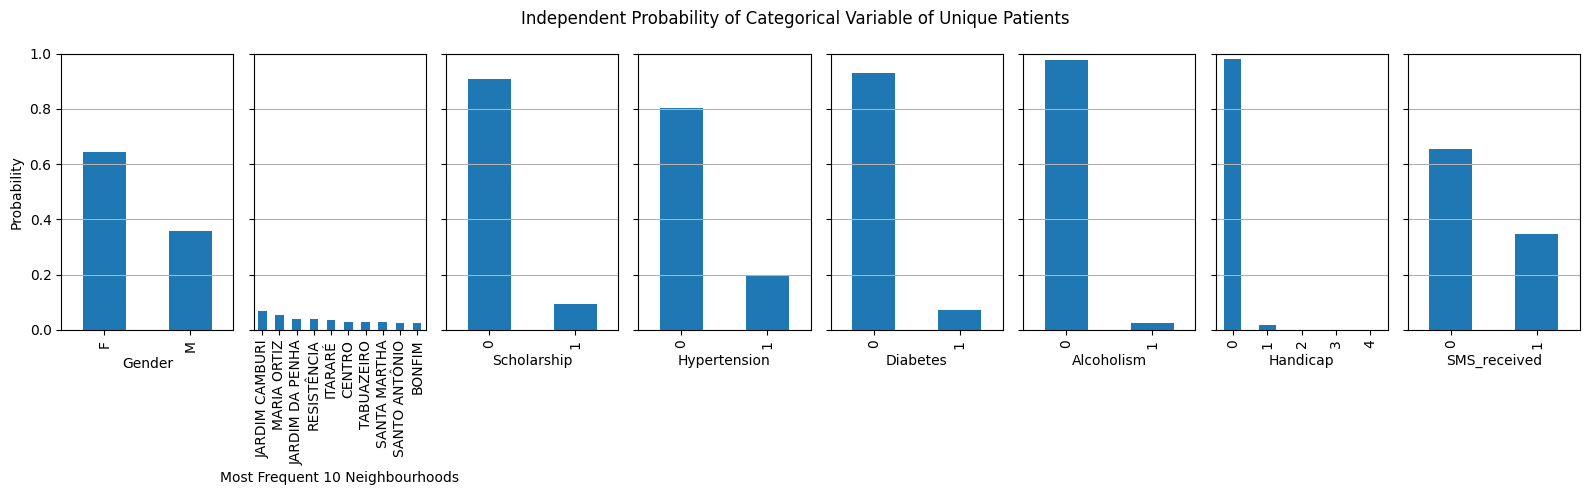

In [9]:
eda.stats_per_unique_patient()

Since, 83% of the patients visit less than 3 times, building the model primarily as a sequence classification problem is not desirable. However, a second level of sequence classification can be added to the repeat patients. This is however, not explored in this analysis.

**Conclusion:** Frame the problem as a binary classification per patient

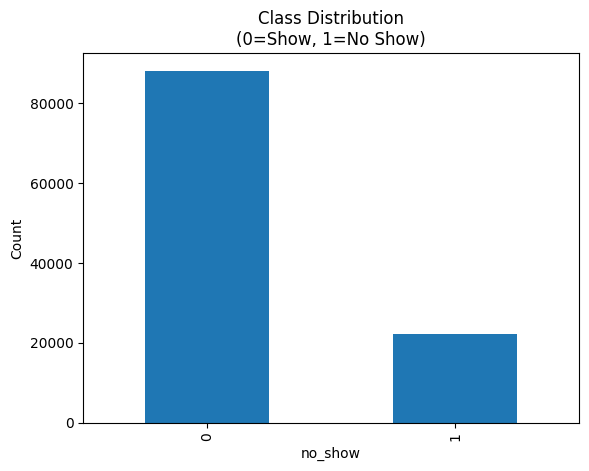

In [10]:
eda.visulaize_class_distribution()

***Conclusion***

**This is an imbalanced classification problem and techniques such as:**
1. oversampling
2. assigning class weights when performing classification
3. creating synthetic data of the imbalanced class using techniques such as SMOTE

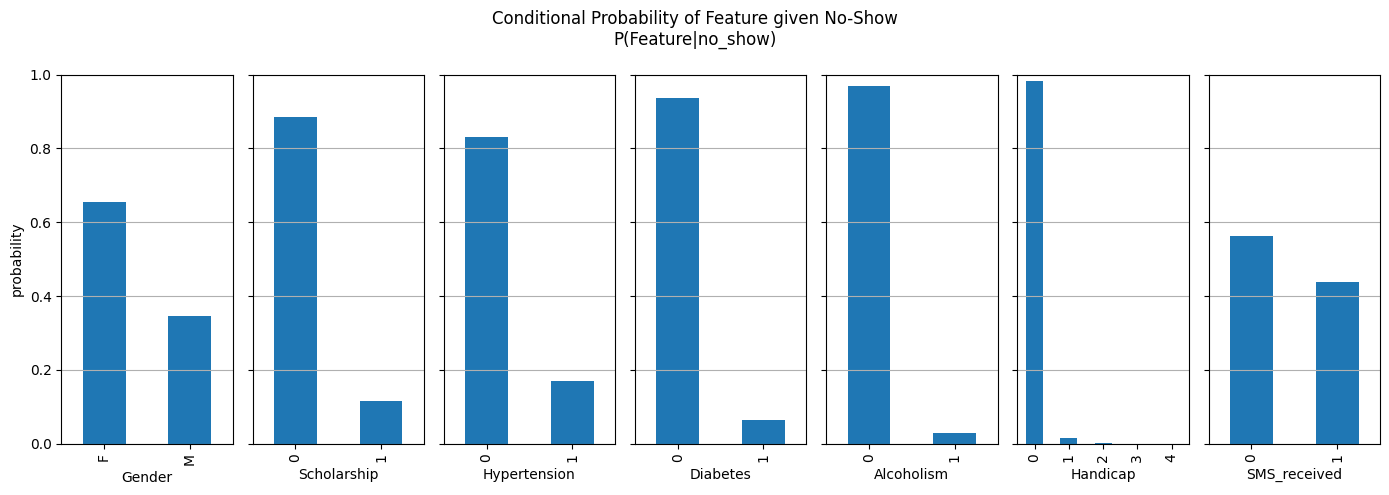

In [11]:
eda.visulaize_no_show_prob_per_variable()

***Conclusion***

**For most variables, the independent and conditional probabilities are very similar. This implies that a person not showing up for an appointment is almost independent of these categorical variables. This means that knowing one of these variables or not doesn't substantially alter the probability of a person not showing up for an appointment. However, joint probabilities are not explored in this section, and a combination of these variables occurring together may impact the outcome.**

# Preprocessing

In [12]:
preprocessor = preprocMedicalAppointment()

In [13]:
print("before", df_medical_appointment.shape)
df_medical_appointment = preprocessor.remove_outliers_age(df_medical_appointment)
print("after", df_medical_appointment.shape)

before (110527, 14)
after (110519, 14)


In [14]:
X_train, y_train, X_test, y_test, X_val, y_val = train_val_test_split(df_medical_appointment, feature_cols=feature_cols, target_col='no_show', test_percent=20)

# Feature Extraction

In [15]:
feature_extractor = featuresMedicalAppointment()

In [16]:
X_train.shape

(88415, 13)

In [17]:
scheduled_after_appointment_strategy = 'drop' # numeric or 'drop'
X_train, y_train = feature_extractor.feat_n_hours_scheduled_before(X_train, y_train, scheduled_after_appointment_strategy=scheduled_after_appointment_strategy)
X_train.shape, y_train.shape

((57602, 14), (57602,))

In [18]:
X_train = feature_extractor.feat_appointment_date(X_train)
X_train.shape

(57602, 16)

In [19]:
infrequent_threshold = 100
X_train = feature_extractor.feat_categorical_to_one_hot_encoding_train(X_train, infrequent_threshold=infrequent_threshold)
X_train.shape

Gender -> n_unique: 2
Neighbourhood -> n_unique: 71
day_of_week -> n_unique: 6


(57602, 92)

In [20]:
columns_to_scale = ['Age']
X_train = feature_extractor.feat_minmax_norm_train(X_train, columns_to_scale)
X_train.shape

(57602, 92)

In [21]:
X_train.drop(columns=['PatientID', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], inplace=True)
X_train.shape

(57602, 88)

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57602 entries, 0 to 57601
Data columns (total 88 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                57602 non-null  float64
 1   Scholarship                        57602 non-null  int64  
 2   Hypertension                       57602 non-null  int64  
 3   Diabetes                           57602 non-null  int64  
 4   Alcoholism                         57602 non-null  int64  
 5   Handicap                           57602 non-null  int64  
 6   SMS_received                       57602 non-null  int64  
 7   n_hours_scheduled_before           57602 non-null  int64  
 8   day_of_month                       57602 non-null  int32  
 9   Gender_F                           57602 non-null  int64  
 10  Gender_M                           57602 non-null  int64  
 11  Neighbourhood_ANDORINHAS           57602 non-null  int

# Feature Selection

>**Permutation Importance**

    One of the most basic questions we might ask of a model is: 
    What features have the biggest impact on predictions? This concept is called feature importance.

    In this notebook we use permutation importance. Compared to most other approaches, permutation importance is:
           - fast to calculate,
           - widely used and understood, and
           - consistent with properties we would want a feature importance measure to have.
    The basic question it answers is: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data? Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions.

>**Hierarchical clustering**

    In hierarchical clustering, we look at every pair of objects and say which two objects are the closest. We then take the closest pair, delete them, and replace them with the midpoint of the two. Then repeat that again and again. Since we are removing points and replacing them with their averages, we are gradually reducing a number of points by pairwise combining. Rather than looking at points, we look at variables and see which two variables are the most similar. In a resulting dendrogram, the vertical axis here is how similar are the two points that are being compared. If they are closer to 0, that means that they are very similar. In this case, (1 - Spearman’s R) is used. So correlation is almost exactly the same as the R², but it’s between two variables rather than a variable and its prediction.

## Feature Selection Method 1: Permutation Importance + Hierarchical Clustering

### Permutation Importance 1

In [24]:
df_feature_importances = feature_selection_permutation_importance(
    X_train, 
    y_train, 
    n_jobs=4, 
    n_repeats=4,
    plot=True,
)

/Users/sudhanshugupta/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/backend/resource_tracker.py:113: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some folders/sempahores might leak.
  warnings.warn(
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'joblib'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'joblib'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'joblib'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'joblib'
/Users/sudhanshugupta/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/backend/resource_tracker.py:113: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some folders/sempahores might leak.
  warnings.warn(
Traceback (most recent call 

BrokenPipeError: [Errno 32] Broken pipe

### Hierarchical Clustering 1

In [ ]:
THRESHOLD_CLUSTERING = 0.75
THRESHOLD_IMPORTANCE = None # Set to None in first iteration

In [ ]:
df_selected_features = feature_selection_hierarchical_clustering(
    X_train, 
    threshold_clustering=THRESHOLD_CLUSTERING, 
    threshold_importance=THRESHOLD_IMPORTANCE, 
    df_feature_importances=df_feature_importances, 
    plot=True,
)

display(df_selected_features)

In [ ]:
FEATURES_PERMUTATION_IMPORTANCE_2 = df_selected_features['feature'].to_list()

### Permutation Importance 2

In [ ]:
df_feature_importances = feature_selection_permutation_importance(
    X_train[FEATURES_PERMUTATION_IMPORTANCE_2],
    y_train,
    n_jobs=4,
    n_repeats=4,
    plot=True,
)

### Hierarchical Clustering 2

In [ ]:
THRESHOLD_CLUSTERING = 0.75 #0.055
THRESHOLD_IMPORTANCE = 0.005

In [ ]:
df_selected_features = feature_selection_hierarchical_clustering(
    X_train[FEATURES_PERMUTATION_IMPORTANCE_2], 
    threshold_clustering=THRESHOLD_CLUSTERING, 
    threshold_importance=THRESHOLD_IMPORTANCE, 
    df_feature_importances=df_feature_importances, 
    plot=True,
)

display(df_selected_features)

In [ ]:
FEATURES_LIST_PI_HC = df_selected_features['feature'].to_list()
len(FEATURES_LIST_PI_HC)

## Feature Selection Method 2: Principal Components Analysis

In [ ]:
feature_extractor.plot_optimal_PCA_components(X_train)

In [ ]:
# feature_extractor.feat_PCA_train(X_train, n_components=10)

The fact that one principal component explains all the variance suggests that the original features are not providing distinct and independent information. Instead, they are highly correlated or redundant with each other.

This method is not used in this analysis further.

## Select the desired feature list

In [25]:
FEATURES_LIST_SELECTED = list(X_train.columns) # FEATURES_LIST_PI_HC / list(X_train.columns)
print(len(FEATURES_LIST_SELECTED))

88


# Classification

add calibration

force infrequent neighborhood classes in test to be same as train

or knoiw the infrequent alreaDY AND FORCE IN BOTH TESTR AND TRAIN

In [26]:
df_metrics = pd.DataFrame()

In [27]:
X_test, y_test = feature_extractor.feat_n_hours_scheduled_before(X_test, y_test, scheduled_after_appointment_strategy=scheduled_after_appointment_strategy)
X_test = feature_extractor.feat_appointment_date(X_test)
X_test = feature_extractor.feat_categorical_to_one_hot_encoding_test(X_test)
X_test = feature_extractor.feat_minmax_norm_test(X_test, columns_to_scale)
X_test.drop(columns=['PatientID', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], inplace=True)
X_test.shape

Gender -> n_unique: 2
Neighbourhood -> n_unique: 71
day_of_week -> n_unique: 6


(14352, 88)

## Logistic Regression Classifier

In [ ]:
clf_logistic_regression = LogisticRegressionClf()
clf_logistic_regression.set_class_weights()
clf_logistic_regression.fit_classifier(X_train[FEATURES_LIST_SELECTED], y_train)

In [ ]:
y_pred = clf_logistic_regression.predict_classifier(X_test[FEATURES_LIST_SELECTED])
precision_lr, recall_lr, f1_lr, accuracy_lr = clf_logistic_regression.evaluate_classifier(y_test, y_pred)

In [ ]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "logistic_regression",
        "precision": precision_lr,
        "recall": recall_lr,
        "f1": f1_lr,
        "accuracy": accuracy_lr,
    }, index=[0])
])
df_metrics

## Random Forest Classifier

In [28]:
clf_rf = RandomForestClf()
clf_rf.set_class_weights()
clf_rf.fit_classifier(X_train[FEATURES_LIST_SELECTED], y_train)

In [29]:
y_pred = clf_rf.predict_classifier(X_test[FEATURES_LIST_SELECTED])
precision_rf, recall_rf, f1_rf, accuracy_rf = clf_rf.evaluate_classifier(y_test, y_pred)

In [30]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "random_forest",
        "precision": precision_rf,
        "recall": recall_rf,
        "f1": f1_rf,
        "accuracy": accuracy_rf,
    }, index=[0])
])
df_metrics

,classifier,precision,recall,f1,accuracy
0,random_forest,0.495738,0.1843,0.268704,0.71328


### Hyperparameter Tuning

**Future Work:** ADD GRAPHS TO SHOW DIFFERENT CLASSIFIERS HYPERPARAMETER TUNING AND SEE WHAT FACTOR MAKES A DIFFERENCE

In [ ]:
param_space = {
    'n_estimators': (10, 500),
    'max_depth': (50, 200),
    'min_samples_split': (2, 100),
    'min_samples_leaf': (5, 100),
    'max_features': (0.2, 1.0),
}

clf_rf.hyperparmater_tuning(X_train[FEATURES_LIST_SELECTED], y_train, param_space, n_iter=50, cv=5, n_jobs=32)

In [ ]:
y_pred = clf_rf.predict_classifier(X_test[FEATURES_LIST_SELECTED])
precision_rf_best, recall_rf_best, f1_rf_best, accuracy_rf_best = clf_rf.evaluate_classifier(y_test, y_pred)

In [ ]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "random_forest_HP_tuned",
        "precision": precision_rf_best,
        "recall": recall_rf_best,
        "f1": f1_rf_best,
        "accuracy": accuracy_rf_best,
    }, index=[0])
])
df_metrics

## XGBoost Classifier

In [ ]:
clf_xgb = XGBClf()
clf_xgb.fit_classifier(X_train[FEATURES_LIST_SELECTED], y_train)

In [ ]:
y_pred = clf_xgb.predict_classifier(X_test[FEATURES_LIST_SELECTED])
precision_xgb, recall_xgb, f1_xgb, accuracy_xgb = clf_xgb.evaluate_classifier(y_test, y_pred)

In [ ]:
threshold_values = np.arange(0, 1, 0.05)
clf_xgb.predict_per_threshold(X_test[FEATURES_LIST_SELECTED], y_test, threshold_values)

In [ ]:
pd.DataFrame.from_dict({
        "classifier": ["XGBoost"],
        "precision": [precision_xgb],
        "recall": [recall_xgb],
        "f1": [f1_xgb],
        "accuracy": [accuracy_xgb],
    })

In [ ]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "XGBoost",
        "precision": precision_xgb,
        "recall": recall_xgb,
        "f1": f1_xgb,
        "accuracy": accuracy_xgb,
    }, index=[0])
])
df_metrics

## MLP Classifier

In [ ]:
clf_mlp = MLPClf()
clf_mlp.set_class_weights()
clf_mlp.fit_classifier(X_train[FEATURES_LIST_SELECTED], y_train)

In [ ]:
y_pred = clf_mlp.predict_classifier(X_test[FEATURES_LIST_SELECTED])
precision_mlp, recall_mlp, f1_mlp, accuracy_mlp = clf_mlp.evaluate_classifier(y_test, y_pred)

In [ ]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "MLP",
        "precision": precision_mlp,
        "recall": recall_mlp,
        "f1": f1_mlp,
        "accuracy": accuracy_mlp,
    }, index=[0])
])
df_metrics

In [ ]:
y_pred = clf_mlp.predict_at_threshold(X_test[FEATURES_LIST_SELECTED], 0.4)
precision_mlp_thr_0_4, recall_mlp_thr_0_4, f1_mlp_thr_0_4, accuracy_mlp_thr_0_4 = clf_mlp.evaluate_classifier(y_test, y_pred)

In [ ]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "MLP_thr_0.4",
        "precision": precision_mlp_thr_0_4,
        "recall": recall_mlp_thr_0_4,
        "f1": f1_mlp_thr_0_4,
        "accuracy": accuracy_mlp_thr_0_4,
    }, index=[0])
])
df_metrics

In [ ]:
threshold_values = np.arange(0, 1, 0.05)
clf_mlp.predict_per_threshold(X_test[FEATURES_LIST_SELECTED], y_test, threshold_values)

## Compare Classifers

In [ ]:
compare_performances_across_classifiers(df_metrics)

# Error analysis

In [32]:
import giskard

In [33]:
classifier = clf_rf

In [34]:
giskard_model = giskard.Model(
    model=classifier.predict_proba_classifier,  # A prediction function that encapsulates all the data pre-processing steps and that could be executed with the dataset used by the scan.
    model_type="classification",  # Either regression, classification or text_generation.
    name="Medical Appointment",  # Optional
    classification_labels=np.unique(y_test),  # Their order MUST be identical to the prediction_function's output order
    feature_names=FEATURES_LIST_SELECTED,  # Default: all columns of your dataset
    # classification_threshold=0.5,  # Default: 0.5
)

giskard_dataset = giskard.Dataset(pd.concat([X_test, pd.Series(y_test, name='target')], axis=1))

# Then apply the scan
results = giskard.scan(giskard_model, giskard_dataset)

/Users/sudhanshugupta/Library/Python/3.9/lib/python/site-packages/giskard/core/dataset_validation.py:13: UserWarning: You did not provide the optional argument 'target'. 'target' is the column name in df corresponding to the actual target variable (ground truth).
  warning(


Your model is successfully validated.
🔎 Running scan…
2023-09-03 20:43:06,821 pid:62307 MainThread giskard.scanner.logger INFO     Running detectors: ['PerformanceBiasDetector', 'TextPerturbationDetector', 'EthicalBiasDetector', 'DataLeakageDetector', 'StochasticityDetector', 'OverconfidenceDetector', 'UnderconfidenceDetector', 'SpuriousCorrelationDetector']
Running detector PerformanceBiasDetector…2023-09-03 20:43:06,822 pid:62307 MainThread giskard.scanner.logger INFO     PerformanceBiasDetector: Skipping detection because the dataset has no target column.
 0 issues detected. (Took 0:00:00.000740)
Running detector TextPerturbationDetector…2023-09-03 20:43:06,824 pid:62307 MainThread giskard.scanner.logger INFO     TextPerturbationDetector: Running with transformations=['Transform to uppercase', 'Transform to lowercase', 'Transform to title case', 'Add typos', 'Punctuation Removal'] threshold=None output_sensitivity=None num_samples=None
 0 issues detected. (Took 0:00:00.000588)
Runni

In [35]:
display(results)

<iframe id="scan-11498157920" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:co